# Prediccion de Ventas en una Serie de Tiempo

## Forecasting in Time Series

Objetivo: Predecir un año de Ventas dados 6 años de datos (Periodicidad Mensual), aplicando conceptos de Series de Tiempo y algoritmos de forecasting en Aprendizaje No Supervisado

## Pasos:
### 0. Preparacion Hardware-Software
Requerimientos:
Python 3.6, Anaconda, Keras, Tensorflow, Scikit Learn, Scipy.

##### Comandos para instalar desde un Anaconda Prompt:
`conda create -n prediccionventas python=3.6 numpy scipy matplotlib spyder pandas
activate prediccionventas `
#computador sin gpu

`pip install --ignore-installed --upgrade tensorflow`
#computador GPU

`pip install --ignore-installed --upgrade tensorflow-gpu`
`conda install mkl-service m2w64-toolchain`
`pip install pydot keras`
> Si existe problemas por las versiones de las librerias, se recomienda importar el ambiente Conda del repositorio, el cual tiene los requerimientos configurados https://github.com/FreddieAbad/PrediccionAUCORP/tree/master/Entrega/Ambiente%20Conda

### 1. Obtencion de datos
No Aplica, los datos fueron provistos. 
### 2. Preparar los datos
Los atributos de la data corresponden a un total de 16 atributos, correspondientes a fechas, ventas, y variaciones estadísticas útiles para el fin de este proyecto.


In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

In [3]:
# cargamos el conjunto de datos
dataframe = read_csv('base_datos_ventas2.csv', sep=';')
dataset = dataframe.columns
print(dataset)

Index(['mes de analisis', 'Año', 'CATEGORIA', 'CANTIDAD_CLASIF_A',
       'ventas_totales_Veh_livianos', 'Tasa de inflación (mensual)',
       'Población Económicamente Activa (Nacional)',
       'Exportaciones totales (USD)',
       'PRODUCTO INTERNO BRUTO (PIB) TRIMESTRAL (MILES DE DOL)',
       'Balanza comercial total (millones de usd)',
       ' Valor Unitario del petroleo Promedio (eje der.) ',
       'EXPORTACIONES PETROLERAS (miles de USD) FOB (der)',
       'Import. CIF MILLONES USD', 'Exp. no petroleras MILLONES USD',
       'IMPORTACIONES Petroleras', 'IMPORTACIONES No Petroleras'],
      dtype='object')


Para seguir el proceso, se necesita entender los atributos y sus variaciones, por tanto se muestra a continuacion las graficas de los atributos en los cuales el negocio tiene una afeccion directa (CANTIDAD_CLASIF_A, Ventas de vehiculos livianos, Tasa Inflacion). Los demás atributos no, ya que no dependen directamente del negocio, sino del variables que dicta la situacion del pais.

#### Gráficas de cada atributo a travez del tiempo

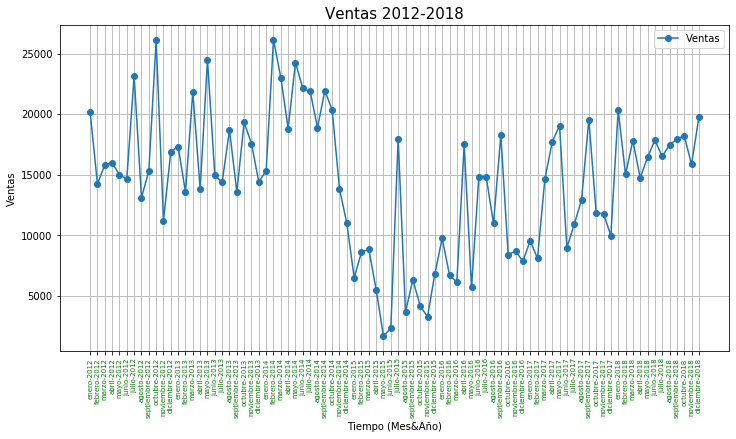

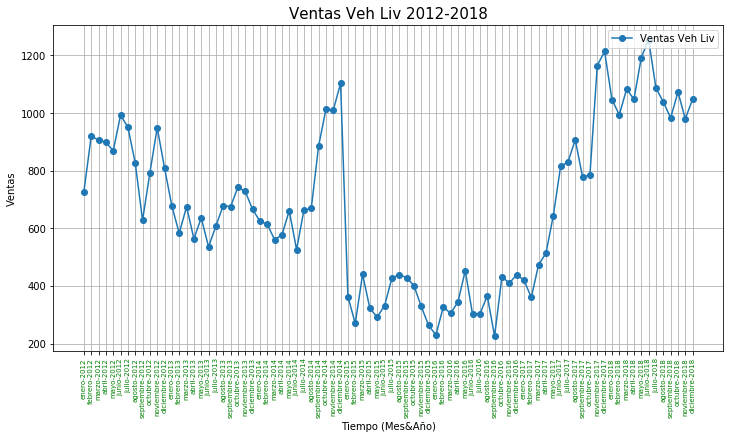

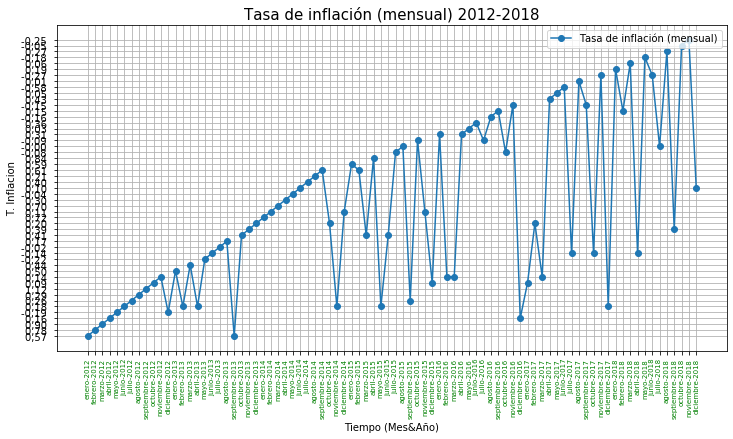

In [4]:
def graficaAtributo(atributo,nombreLeyenda,titulo,xetiqueta,yetiqueta,nombreArchivo):
    figure(figsize=(12,6))
    dataframe['mes de analisis'] = dataframe['mes de analisis'].astype(str)
    dataframe['Año'] = dataframe['Año'].astype(str)
    plt.plot(dataframe['mes de analisis']+'-'+dataframe['Año'], dataframe[atributo], "-o")
    plt.legend([nombreLeyenda], loc = 'upper right')
    plt.grid(True)
    plt.title(titulo, fontsize = 15)
    plt.xlabel(xetiqueta, fontsize = 10)
    plt.ylabel(yetiqueta, fontsize = 10)
    plt.xticks(fontsize=7, color = 'g', rotation = 90) 
    plt.savefig(nombreArchivo, dpi=300)
#Grafica del atributo a predecir
graficaAtributo('CANTIDAD_CLASIF_A','Ventas',"Ventas 2012-2018","Tiempo (Mes&Año)","Ventas",'ventasGrafica.svg')
#Grafica de Venta de Vehiculos livianos
graficaAtributo('ventas_totales_Veh_livianos','Ventas Veh Liv',"Ventas Veh Liv 2012-2018","Tiempo (Mes&Año)","Ventas",'ventas_totales_Veh_livianos.svg')
#Grafica de Venta de Vehiculos livianos
graficaAtributo('Tasa de inflación (mensual)','Tasa de inflación (mensual)',"Tasa de inflación (mensual) 2012-2018","Tiempo (Mes&Año)","T. Inflacion",'t_inflacion.svg')



##### Se debe reducir la dimensionalidad de los datos, evitando atributos innecesarios (aplicacion de PCA)
El atributo Categoria no muestra valores influyentes en nuestra data, se mantiene el valor "A", si el modelo a entrenar toma en cuenta este atributo, se malgastarian recursos. El atributo Mes y Año se unen en un solo atributo, ya que al ser una serie de tiempo, estos dos fijan los demas valores a un solo valor en el tiempo.

### Pendiente
Se aplica PCA, para obtener atributos netamente necesarios e independientes de otros atributos.
#### ====
> Principal Component Analysis es una técnica de Extracción de Características donde se combinan las entradas de una manera específica, para eliminar algunas de las variables «menos importantes» manteniendo la parte más importante todas las variables. Luego de aplicar PCA, todas las nuevas variables son independientes una de otra.
#### ====
La data se normaliza y estandariza, los modelos se entrenaran con estos dos datos y con los datos originales, para conocer cual da un mejor resultado.

##### Estandarización 
Refiere al desplazamiento de la distribución de cada atributo para tener una media de cero y una desviación estándar de uno (varianza unitaria).Es útil estandarizar atributos para un modelo que se basa en la distribución de atributos como los procesos gaussianos.
##### Normalización 
Refiere a reescalar atributos numéricos de valor real en el rango 0 y 1. Es útil escalar los atributos de entrada para un modelo que se basa en la magnitud de los valores, como las medidas de distancia utilizadas en los vecinos k más cercanos y en la preparación de coeficientes de regresión.

In [5]:
#Eliminacion de Atributos Innecesarios & Fusion Atributo Mes-Año
dataframe['mes de analisis'] = dataframe['mes de analisis'].astype(str)
dataframe['Año'] = dataframe['Año'].astype(str)
dataframe['Fecha']= dataframe['mes de analisis']+'-'+dataframe['Año']
dataframe=dataframe.drop(columns=['mes de analisis', 'Año','CATEGORIA'])



In [6]:
#Preprocesamiento de los datos, para posteriormente Normalizarlo (Al no realizarlo se trata como un string, y no como un Float32)
from sklearn.preprocessing import LabelEncoder
for column in dataframe.columns:
    if dataframe[column].dtype == type(object):
        le = LabelEncoder()
        dataframe[column] = le.fit_transform(dataframe[column])


In [21]:
#Normalizacion
from sklearn import preprocessing
import pandas
X = dataframe.values
normalized_X = preprocessing.normalize(X)
dataframeNormalize = pandas.DataFrame(normalized_X, columns = dataframe.columns)  
#print(dataframeNormalize)
#print(normalized_X)
export_csv = dataframeNormalize.to_csv (r'dataframeNormalize.csv', index = None, header=True)

In [22]:
#Standarizacion
from sklearn import preprocessing
Z = dataframe.values
standardized_X = preprocessing.scale(Z)
dataframeStandarized = pandas.DataFrame(standardized_X, columns = dataframe.columns)  


#print(standardized_X)
export_csv = dataframeStandarized.to_csv (r'dataframeStandarized.csv', index = None, header=True)

>La separacion de los datos para entrenamiento y test, usualmente se debe realizar randomicamente, para evitar Overfiting, sin embargo, en el caso de las series de tiempo se debe cuidar la secuencialidad. Asi se garantizara los patrones que puedan exitir, ya sea por epoca de año u otras caracteristicas del dataset.

In [29]:
### 2.1 Separacion de datos segun la Regla de Pareto 80/20.
traindfStandarize = dataframeStandarized.loc[0:66]
testdfStandarize = dataframeStandarized.loc[67:83]
traindfNormalize = dataframeNormalize.loc[0:66]
testdfNormalize = dataframeNormalize.loc[67:83]
traindfOriginal = dataframe.loc[0:66]
testdfOriginal = dataframe.loc[67:83]
print ("Verificacion de valores train - test ")
print (str(traindfStandarize.shape) + ' & '+str(testdfStandarize.shape))
print (str(traindfNormalize.shape) + ' & '+str(testdfNormalize.shape))
print (str(traindfOriginal.shape) + ' & '+str(testdfOriginal.shape))

export_csv = traindfOriginal.to_csv (r'aucorpTrain.csv', index = None, header=True)
export_csv = testdfOriginal.to_csv (r'aucorpTest.csv', index = None, header=True)

Verificacion de valores train - test 
(67, 14) & (17, 14)
(67, 14) & (17, 14)
(67, 14) & (17, 14)


### > Los datos estan limpios, se puede proceder con los modelos de entrenamiento
### 3. Elegir el modelo
Al ser un problema de prediccion, se puede operar mediante varios algoritmos, sin embargo, uno de los requerimientos fue el realizarlo mediante un **Perceptron Multicapa (MLP)**.
Si bien, es posible realizarlo por una MLP, los errores usualmente suelen ser grandes, por tal se procedera a realizar 3 casos de estudio con 3, 5, 11 capas intermedias.
Las series de tiempo suelen tener mejores resultados con otro tipo de algoritmos, tales como los **LSTM (Long short-term memory)**, **RNN(Recurrent Neural Network)** . 
Se realizara tambien la prediccion con estos algoritmos, y finalmente se procedera a contrastar los resultados, para conocer cual fue el mejor método.

### 4. Desarrollo Modelos
Prediccion. Resultados:
##### Caso 1
Configuracion: Learning Rate 0.3 Epocas 20 Hidden Layers 3

![RESULT1.png](https://raw.githubusercontent.com/FreddieAbad/PrediccionAUCORP/master/ForecastWEKA/RESULT3.png?token=AJGK4NMNIC5WTJ5LGDDTBTS5OD4PS)
      

| Mes | Prediccion CANTIDAD_CLASIF_A |
| :-------------: | :-------------: |
| Enero 2019 | 19539.9719 |
| Febrero 2019 | 16205.9172 |
| Marzo 2019 | 3774.9766 |
| Abril 2019 | 21806.4895 |
| Mayo 2019 | 33265.9147 |
| Junio 2019 | 26336.9169 |
| Julio 2019 | 23226.3605 |
| Agosto 2019 | 29075.6198 |
| Septiembre 2019 | 39265.0998 |
| Octubre 2019 | 38623.6279 |
| Noviembre 2019 | 24892.4676 |
| Diciembre 2019 | 9921.7544 |         

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

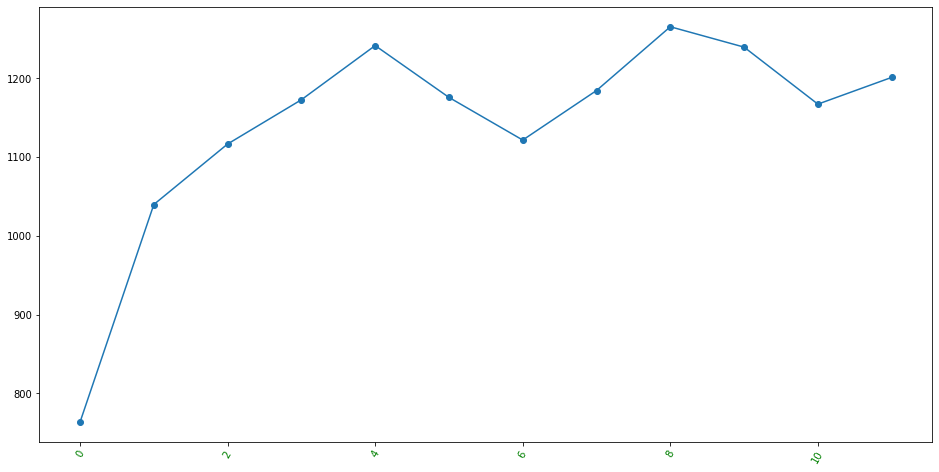

In [45]:
### Error
#meses=["Enero 2019","Febrero 2019","Marzo 2019","Abril 2019","Mayo 2019","Junio 2019","Julio 2019","Agosto 2019","Septiembre 2019","Octubre 2019","Noviembre 2019","Diciembre 2019"] 
mae=[763.4624,1039.8887, 1116.745,1172.9777,1241.7909,1175.9647, 1121.783,1184.7128,1265.7152,  1239.83,1167.4088,1201.3861]
figure(figsize=(16,8))
plt.plot(mae, "-o")
plt.xticks(fontsize=10, color = 'g', rotation = 60) 


##### Caso 2
Configuracion: Learning Rate 0.1 Epocas 20 Hidden Layers 20


![RESULT3.png](https://raw.githubusercontent.com/FreddieAbad/PrediccionAUCORP/master/ForecastWEKA/RESULT2.png?token=AJGK4NIZ6M7Y6XYQPPITIVC5OD35Y)


| Mes | Prediccion CANTIDAD_CLASIF_A |
| :-------------: | :-------------: |
| Enero 2019 | 16698.862 |
| Febrero 2019 | 19353.6774 |
| Marzo 2019 | 14024.0933 |
| Abril 2019 | 22657.4798 |
| Mayo 2019 | 23203.0621 |
| Junio 2019 | 16955.6281 |
| Julio 2019 | 18131.2674 |
| Agosto 2019 | 16285.8306 |
| Septiembre 2019 | 15794.0808 |
| Octubre 2019 | 11088.6973 |
| Noviembre 2019 | 12406.8213 |
| Diciembre 2019 | 10055.6109 |  

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text xticklabel objects>)

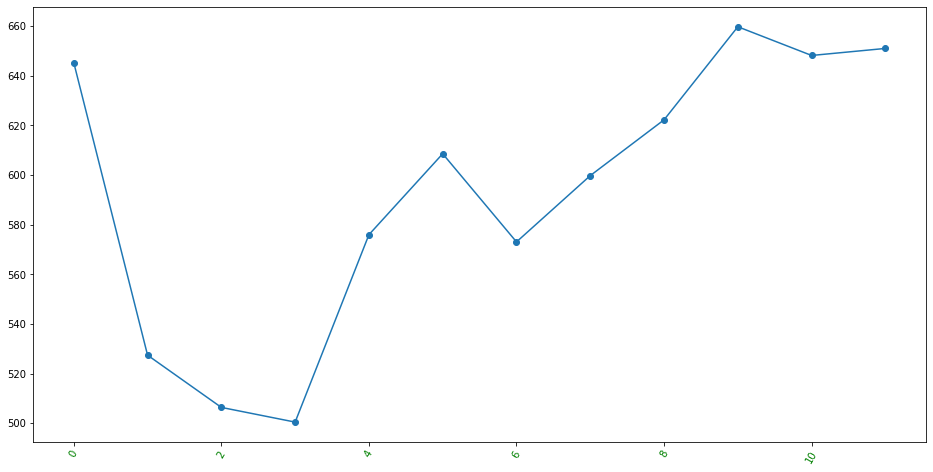

In [44]:
### Error
#meses=["Enero 2019","Febrero 2019","Marzo 2019","Abril 2019","Mayo 2019","Junio 2019","Julio 2019","Agosto 2019","Septiembre 2019","Octubre 2019","Noviembre 2019","Diciembre 2019"] 
mae=[645.2398,527.4249,506.3839,500.4671,575.9494,608.5537,573.0385,599.7472,622.2249,659.7058,648.1423,650.9735]
figure(figsize=(16,8))
plt.plot( mae, "-o")
plt.xticks(fontsize=10, color = 'g', rotation = 60) 

Se evidencia errores inapropiados.

### Configuracion de MLP
##### Descripción Arquitectura 
Red neuronal FeedForward o MLP - Multi-Layered Perceptron, con método de activación tangente hiperbólica pues hay valores transformados entre -1 y 1.


### Configuracion de LSTM
##### Descripción Arquitectura 
Red neuronal FeedForward o MLP - Multi-Layered Perceptron, con método de activación tangente hiperbólica pues hay valores transformados entre -1 y 1.

Cuando se usan LSTM en el dominio de series de tiempo, un parámetro importante para elegir es la longitud de secuencia, que es la ventana para que los LSTM miren hacia atrás. Esto puede verse como algo similar a elegir window_size = 5 ciclos para calcular las características de balanceo en la Plantilla de mantenimiento predictivo que son la media variable y la desviación estándar variable para 21 valores de sensor. La idea de usar LSTM es dejar que el modelo extraiga características abstractas de la secuencia de valores del sensor en la ventana en lugar de diseñarlas manualmente. La expectativa es que si hay un patrón en estos valores del sensor dentro de la ventana antes de la falla, el patrón debe ser codificado por el LSTM. Una ventaja crítica de los LSTM es su capacidad de recordar secuencias a largo plazo (tamaños de ventana) que es difícil de lograr con la ingeniería de características tradicional. Por ejemplo, calcular promedios continuos sobre un tamaño de ventana de 50 ciclos puede conducir a la pérdida de información debido al suavizado y la abstracción de valores durante un período tan largo, en cambio, usar los 50 valores como entrada puede proporcionar mejores resultados. Si bien la ingeniería de características sobre tamaños de ventana grandes puede no tener sentido, los LSTM pueden usar tamaños de ventana más grandes y utilizar toda la información en la ventana como entrada. A continuación, ilustramos el enfoque.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importar el conjunto de entrenamiento
dataset_train = pd.read_csv('aucorpTrain.csv', encoding = "utf-8")
training_set = dataset_train.iloc[:, 2:3].values
# Escalado de características
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Crear una estructura de datos con 12 pasos y 1 salida
X_train = []
y_train = []
for i in range(12, 65):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reorganización
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Parte 2 - Construyendo el RNN
# Importar las bibliotecas y paquetes de Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Inicialicion RNN
regressor = Sequential()

# Capa 1 LSTM y cierta regularización de Dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Capa 2 LSTM y regularización de Dropout
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Capa 3 LSTM y cierta regularización de Dropout
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Capa 4 LSTM y cierta regularización de Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Capa de salida
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Ajuste del RNN al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs = 500, batch_size = 12)

# Parte 3 - Hacer las predicciones y visualizar los resultados
# Datos reales para contraste 
dataset_test = pd.read_csv('aucorpTest.csv', encoding = "utf-8")
real_stock_price = dataset_test.iloc[:, 2:3].values
# Datos prediccion para contraste
dataset_total = pd.concat((dataset_train['CANTIDAD_CLASIF_A'], dataset_test['CANTIDAD_CLASIF_A']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(12, 24):
    X_test.append(inputs[i-12:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Using TensorFlow backend.
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Usuario\Anaconda3\envs\prediccionventas\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Usua




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/500
53/53 [==============================] - 3s 55ms/step - loss: 0.2641
Epoch 2/500
53/53 [==============================] - 0s 2ms/step - loss: 0.1457
Epoch 3/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0834
Epoch 4/500
53/53 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 5/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0823
Epoch 6/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 7/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 8/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 9/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0766
Epoch 10/500
53/53 [==============================] - 0s 2ms/step

53/53 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 180/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 181/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 182/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 183/500
53/53 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 184/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 185/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 186/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 187/500
53/53 [==============================] - 0s 3ms/step - loss: 0.0327
Epoch 188/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 189/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 190/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0341
Epoch 191/500
53/53 [=========

53/53 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 280/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 281/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 282/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 283/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 284/500
53/53 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 285/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0304
Epoch 286/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 287/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 288/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 289/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 290/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 291/500
53/53 [=========

53/53 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 380/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 381/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 382/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 383/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0298
Epoch 384/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 385/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 386/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 387/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 388/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 389/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 390/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 391/500
53/53 [=========

53/53 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 480/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 481/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 482/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0303
Epoch 483/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 484/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 485/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 486/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 487/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 488/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 489/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 490/500
53/53 [==============================] - 0s 2ms/step - loss: 0.0309
Epoch 491/500
53/53 [=========

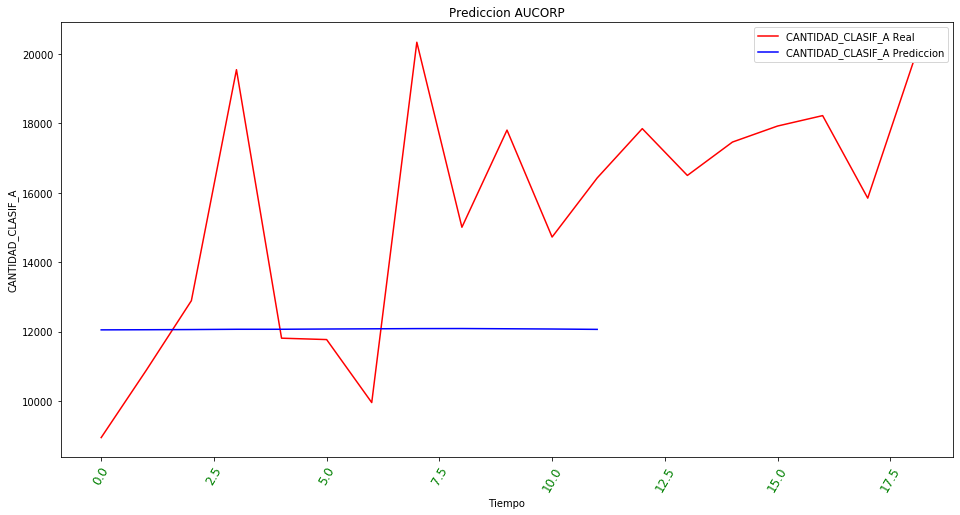

In [41]:
# Visualising the results
meses=["Enero 2019","Febrero 2019","Marzo 2019","Abril 2019","Mayo 2019","Junio 2019","Julio 2019","Agosto 2019","Septiembre 2019","Octubre 2019","Noviembre 2019","Diciembre 2019"] 

figure(figsize=(16,8))
plt.plot(real_stock_price, color = 'red', label = 'CANTIDAD_CLASIF_A Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'CANTIDAD_CLASIF_A Prediccion')
plt.title('Prediccion AUCORP')
plt.xlabel('Tiempo')
plt.ylabel('CANTIDAD_CLASIF_A')
plt.legend()
plt.xticks(fontsize=12, color = 'g', rotation = 60) 

plt.show()
